# Попиксельное преобразование изображений

В этом блокноте мы рассмотрим простой пример попиксельных изменений (преобразований) изображений.

Для начала установим необходимую версию библиотеки и подключим то, чем будем пользоваться в дальнейшем.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl

Считаем исходное изображение и переведем его из цветового пространства BGR в привычное RGB. Представление картинки — тензор. В элементе <code>img_original[i][j]</code> содержится $3$ значения, равные интенсивностям пикселя $(i, j)$ относительно трех цветовых каналов; значения находятся в диапазоне $[0, 255] \cap \mathbb Z$.

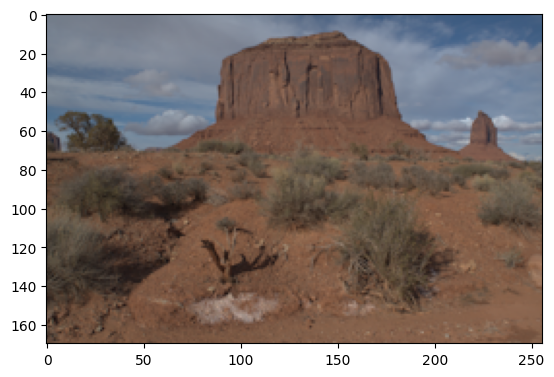

In [2]:
img_original = cv2.imread('./a0001-jmac_DSC1459.dng')
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.show()

Найдем ширину, высоту и среднее значение интенсивности пикселя исходного изображения:

In [3]:
print("высота:", img_original.shape[0], "ширина:", img_original.shape[1])
print("среднее значение интенсивности пикселя:", np.mean(img_original))

высота: 170 ширина: 256
среднее значение интенсивности пикселя: 97.55773590686275


## Изменение экспозиции вручную

Применим к каждому пикселю преобразование, задаваемое следующим образом: $I(out) = I(in) \cdot 2^p$, где $p$ - некоторый параметр из $[-1,1]$. Пусть, скажем, $p = 0.8$.

In [4]:
exposition = 0.8

In [5]:
def exposure(image, p):
    return image.copy() * (2 ** p)

img_result = exposure(img_original, exposition)


Посмотрим на новое изображение

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


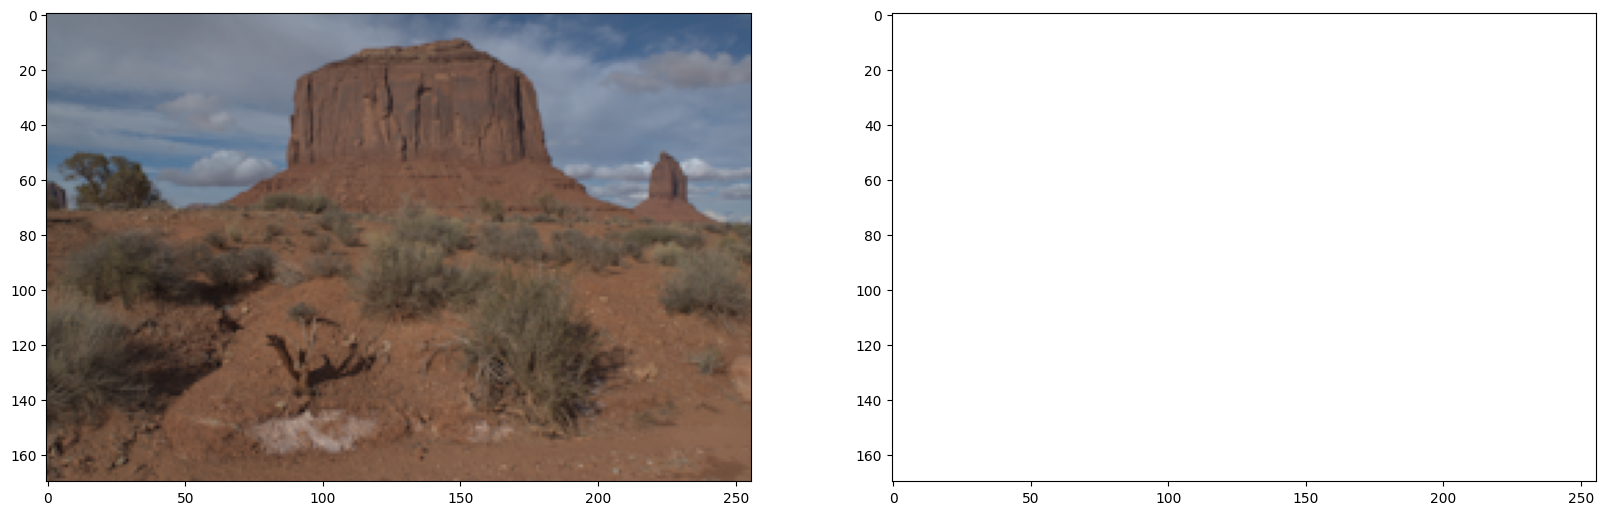

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_original)
axes[1].imshow(img_result)

Новое изображение нам не увидеть. Разберемся, в чем причина. Дело в том, что рассматриваемое преобразование, по своей сути, просто изменяет значение интенсивности каждого пикселя в $2^p$ раз. Очевидно, что, во-первых, могут быть получены значения большие, чем 255, во-вторых, значения скорее всего не будут целыми:

In [7]:
img_result[50][50]

array([200.22662956, 231.56644984, 268.1295735 ])

Если мы попытаемся избавиться только от первой проблемы, то изображение мы получим, но совсем не то, которое хотели:

In [8]:
def exposure(image, p):
    img_result = image.copy()
    for i in range(0, img_result.shape[0]):
      for j in range(0, img_result.shape[1]):
        img_result[i,j] = (round(img_result[i,j][0]*2**p,0),round(img_result[i,j][1]*2**p,0),round(img_result[i,j][2]*2**p,0))
    return img_result

img_result = exposure(img_original, exposition)

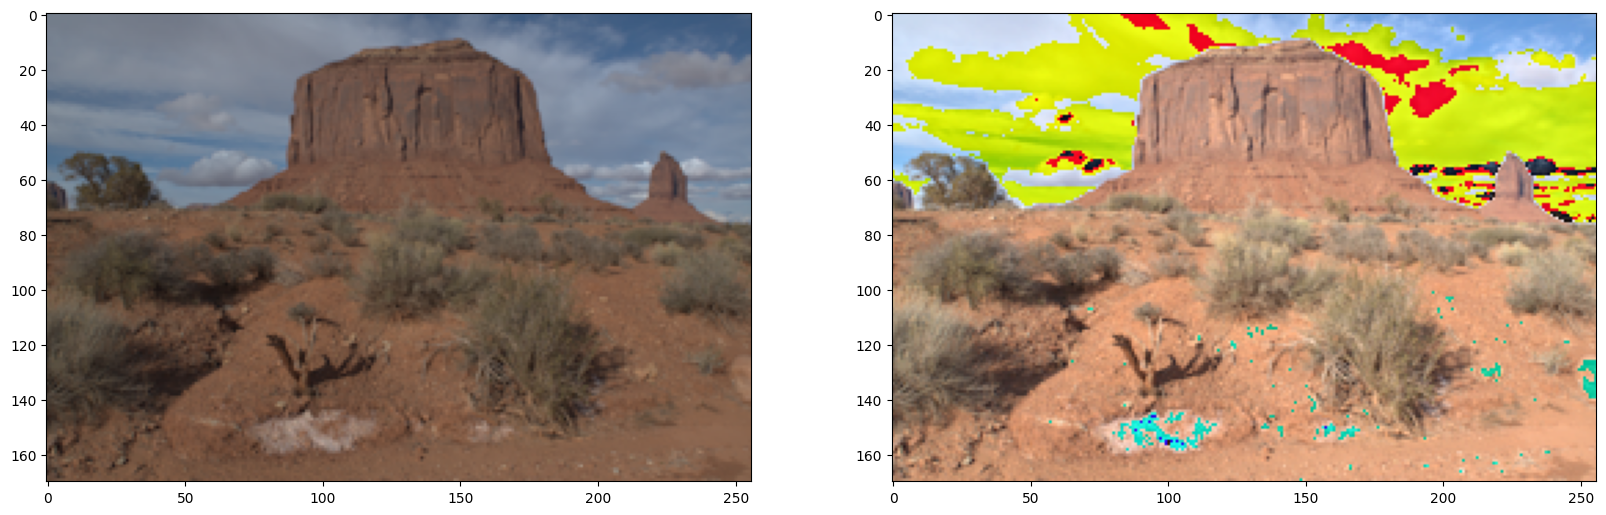

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_original)
axes[1].imshow(img_result)

Изображение в этом конкретном случае хоть и стало стетлее, но с цветом тут явно что-то не то. Дело заключается в способе хранения самого изображения. Из-за того, что для хранения значения интенсивности отведено $8$ бит, при превышении значения в $255$ происходит циклический сдвиг (берется остаток по $\mod 256)$. Например, пиксель
<code>img_result[50][50]</code> имеет следующие значения интенсивностей (после округления):

$$
[200, 232, 268],
$$
но из-за циклического сдвига результат другой ($268 \mod 256 = 12$):

In [10]:
img_result[50][50]

array([200, 232,  12], dtype=uint8)

Логичным кажется следующее решение. Нецелые значения будем округлять, а значения, превосходящие 255, будем считать равными 255. Проверим, что это нам даст.

In [11]:
def exposure(image, p):
    img_result = np.round(image.copy() * (2 ** p),0)
    img_result = img_result.astype(int)
    for i in range(img_result.shape[0]):
      for j in range(img_result.shape[1]):
        for k in range(img_result.shape[2]):
          if img_result[i][j][k] > 255:
            img_result[i][j][k] = 255
    return img_result


img_result = exposure(img_original, exposition)


In [12]:
img_result[50][50]

array([200, 232, 255])

Построим изображение

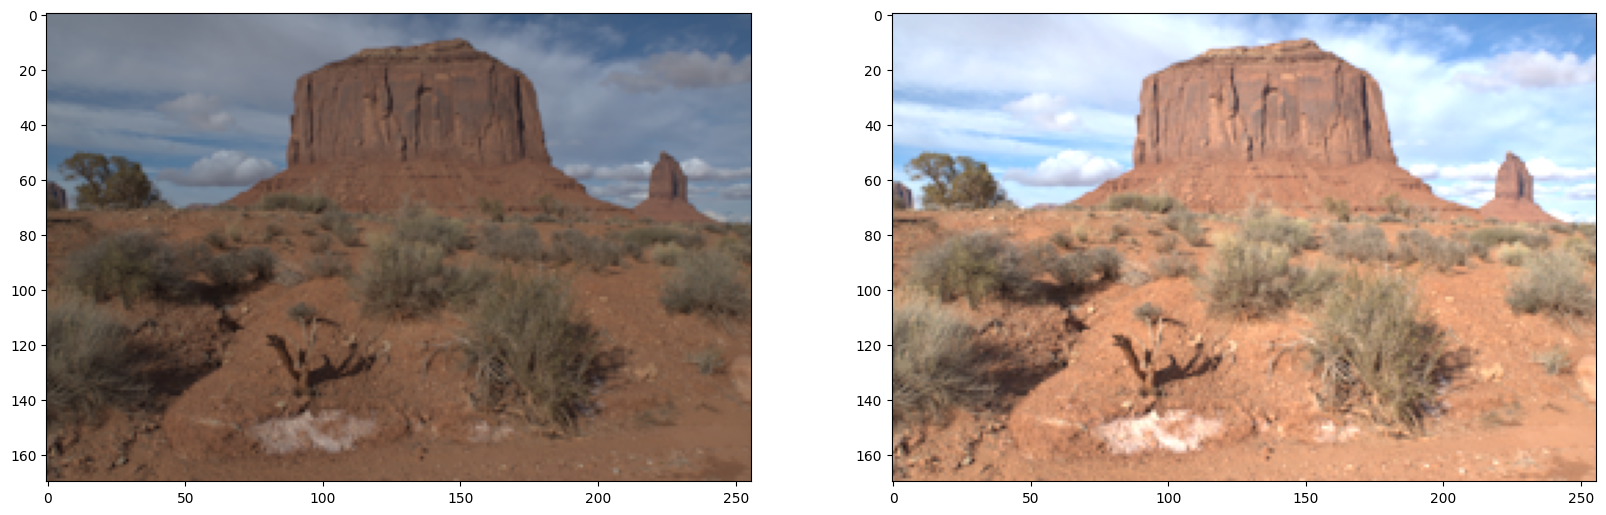

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_original)
axes[1].imshow(img_result)

Cравним средние значения интенсивности пикселя для исходного и модифицированного изображений:

In [14]:
print("Среднее значение интенсивности пикселя исходного изображения:", np.mean(img_original))
print("Среднее значение интенсивности пикселя модифицированного изображения:", np.mean(img_result))

Среднее значение интенсивности пикселя исходного изображения: 97.55773590686275
Среднее значение интенсивности пикселя модифицированного изображения: 168.64738051470587


Для большей наглядности сравним гистограммы исходного и измененного изображений:

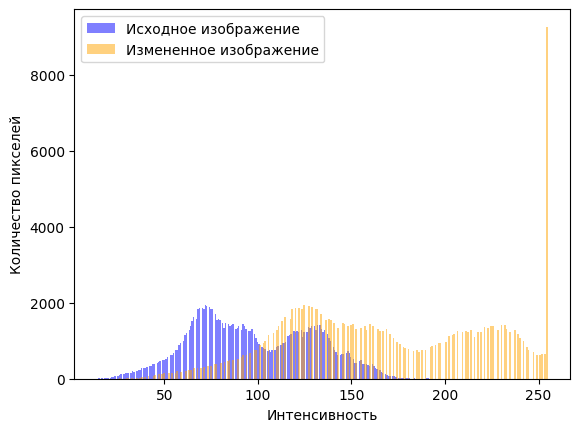

In [15]:
plt.hist(img_original.ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.hist(img_result.ravel(), bins = 256, color = 'Orange', alpha = 0.5)
plt.legend(['Исходное изображение', 'Измененное изображение'])
plt.xlabel('Интенсивность')
plt.ylabel('Количество пикселей')
plt.show()

Измененное изображение сместилось вправо (в более светлую область), чего и следовало ожидать. При этом достаточно большое количество пикселей имеет значение, равное 255.

Самостоятельно предлагается посмотреть понижение яркости, где соответсвующая гистограмма сместится влево.

# Изменение экспозиции при помощи библиотеки

Попробуем повторить произведенные преобразования средствами библиотеки CV2. Для этого нам потребуется сохранить изображение в файл, а затем произвести чтение из файла. При этом файл должен быть сжат алгоритмом без потери качества (например, подойдет .png; при использовании, например, .jpeg, результат будет немного другим).

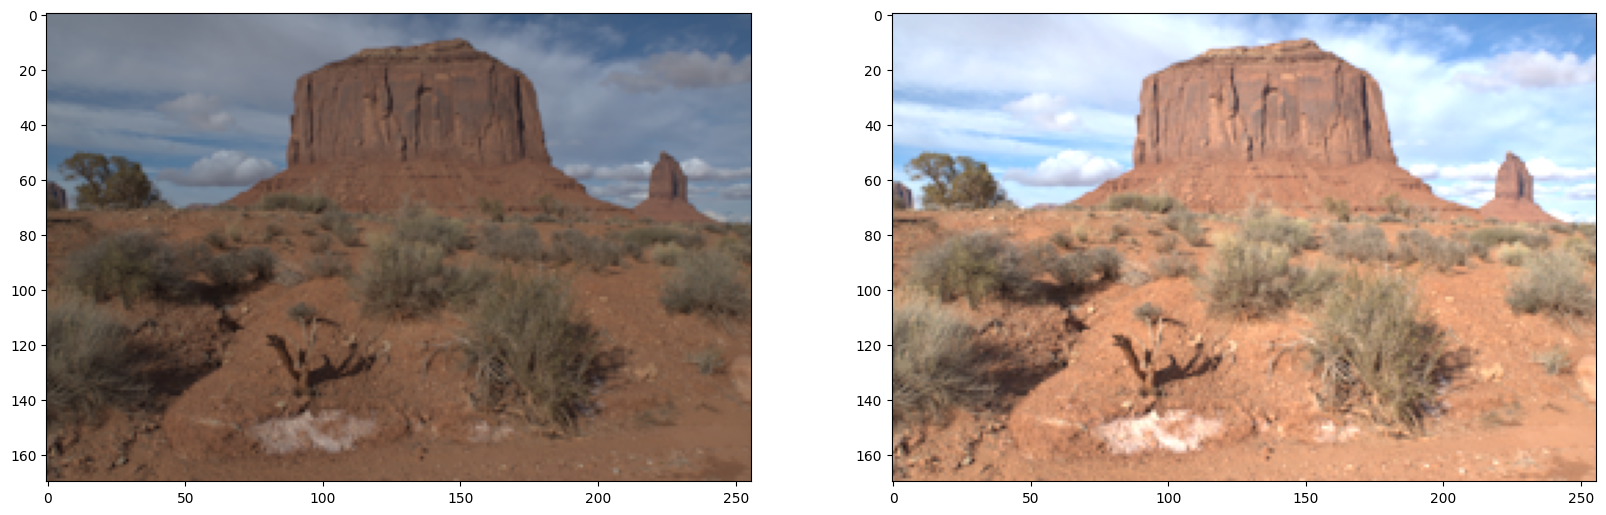

In [16]:
def exposure(image, p):
    return image.copy() * (2 ** p)

#Преобразование
img_result_lib = exposure(img_original, exposition)
#Сохранение в файл
cv2.imwrite("img_result_lib.png", img_result_lib)
#Чтение из файла
img_result_lib = cv2.imread("img_result_lib.png")


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_original)
axes[1].imshow(img_result_lib)

In [17]:
print("Среднее значение интенсивности пикселя изображения, измененного вручную:", np.mean(img_result))
print("Среднее значение интенсивности пикселя изображения, измененного библиотекой:", np.mean(img_result_lib))

Среднее значение интенсивности пикселя изображения, измененного вручную: 168.64738051470587
Среднее значение интенсивности пикселя изображения, измененного библиотекой: 168.64738051470587


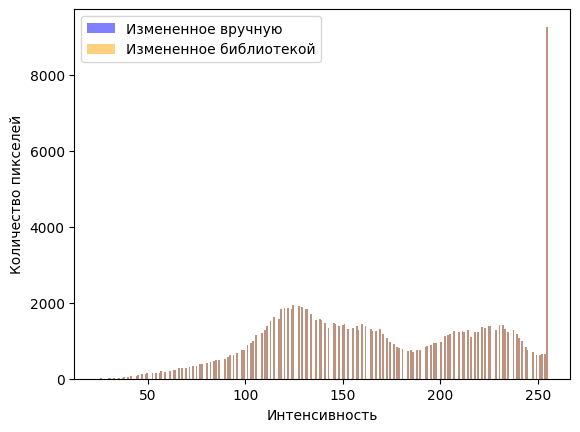

In [18]:
plt.hist(img_result_lib.ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.hist(img_result.ravel(), bins = 256, color = 'Orange', alpha = 0.5)
plt.legend(['Измененное вручную', 'Измененное библиотекой'])
plt.xlabel('Интенсивность')
plt.ylabel('Количество пикселей')
plt.show()

In [19]:
flag = True
for i in range(img_result.shape[0]):
      for j in range(img_result.shape[1]):
        for k in range(img_result.shape[2]):
          if (img_result[i][j][k] != img_result_lib[i][j][k]):
            flag = False
if flag == True:
  print('Результаты полностью совпали!')
else:
  print('Результаты не совпали!')

Результаты полностью совпали!
